<ipython-input-7-cb9bf263b3c3>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['tweet'].fillna('', inplace=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


402/402 ━━━━━━━━━━━━━━━━━━━━ 60s 133ms/step - accuracy: 0.7753 - loss: 0.4463 - val_accuracy: 0.9014 - val_loss: 0.2353
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - accuracy: 0.9309 - loss: 0.1718 - val_accuracy: 0.9266 - val_loss: 0.1823
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 51s 128ms/step - accuracy: 0.9579 - loss: 0.1096 - val_accuracy: 0.9375 - val_loss: 0.1715
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 52s 128ms/step - accuracy: 0.9687 - loss: 0.0795 - val_accuracy: 0.9359 - val_loss: 0.1770
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 83s 132ms/step - accuracy: 0.9763 - loss: 0.0598 - val_accuracy: 0.9341 - val_loss: 0.1950
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.9799 - loss: 0.0484 - val_accuracy: 0.9434 - val_loss: 0.1882
Test Accuracy: 0.9434


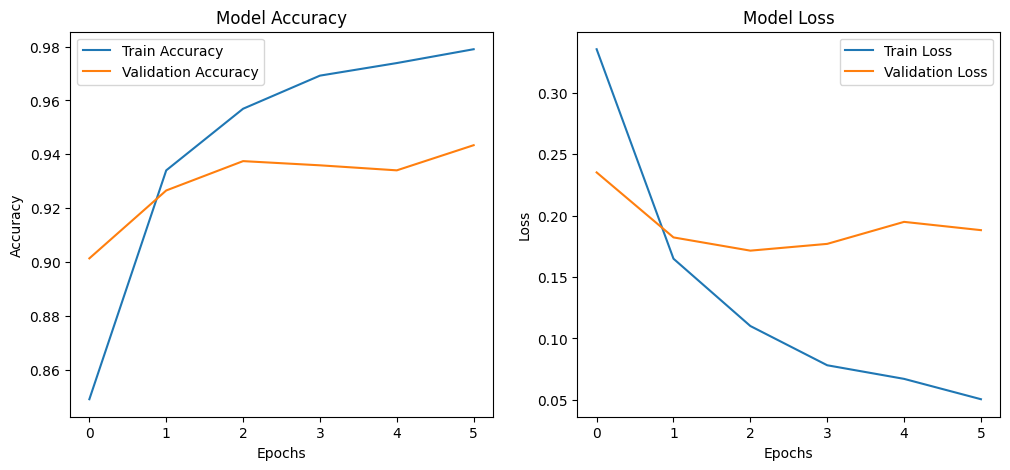

101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1907
           1       0.93      0.93      0.93      1308

    accuracy                           0.94      3215
   macro avg       0.94      0.94      0.94      3215
weighted avg       0.94      0.94      0.94      3215



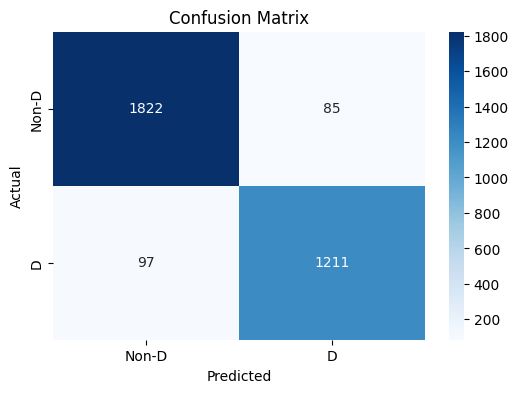

In [7]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load datasets
d_tweets = pd.read_csv('/d_tweets.csv')
non_d_tweets = pd.read_csv('/non_d_tweets.csv')
clean_d_tweets = pd.read_csv('/clean_d_tweets.csv')
clean_non_d_tweets = pd.read_csv('/clean_non_d_tweets.csv')

# Combine datasets and label
d_tweets['label'] = 1
non_d_tweets['label'] = 0
clean_d_tweets['label'] = 1
clean_non_d_tweets['label'] = 0
data = pd.concat([d_tweets, non_d_tweets, clean_d_tweets, clean_non_d_tweets])

# Handle missing values
data['tweet'].fillna('', inplace=True)

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

data['tweet'] = data['tweet'].apply(preprocess_text)

# Create embedding matrix
vocab_size = 5000
embedding_dim = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(data['tweet'])
word_index = tokenizer.word_index

# Tokenize and pad sequences
sequences = tokenizer.texts_to_sequences(data['tweet'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded, data['label'], test_size=0.2, random_state=42)

# Build model with GRU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-D', 'D'], yticklabels=['Non-D', 'D'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
